In [1]:
import tensorflow as tf
import simplejson
import matplotlib.pyplot as plt
%matplotlib inline
import threading
import tensorflow.contrib.slim as slim
from utils import data_utils, train_utils
import datetime
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [2]:
def argument_scope(H, phase):
    '''
    This returns the arg_scope for slim.arg_scope(), which defines the options for slim.functions
    '''
    padding = H['padding']
    is_training = {'train': True, 'validate': False, 'test': False}[phase]
    pool_kernel = [2, 2]
    pool_stride = 2

    
    params = {
        "decay": 0.997,
        "epsilon": 0.001,
    }

    with slim.arg_scope([slim.conv2d], 
                        # slim.relu would raise an error here
                        activation_fn=tf.nn.relu, 
                        padding=padding, 
                        normalizer_fn=slim.batch_norm, 
                        # normalizer_fn=None,
                        weights_initializer=tf.contrib.layers.variance_scaling_initializer()):
        with slim.arg_scope([slim.batch_norm, slim.dropout], is_training=is_training):
            with slim.arg_scope([slim.max_pool2d], stride=pool_stride, kernel_size=pool_kernel):
                with slim.arg_scope([slim.conv2d_transpose], 
                                    activation_fn=None, 
                                    normalizer_fn=None,
                                    padding=padding, 
                                    weights_initializer=tf.contrib.layers.variance_scaling_initializer()) as sc:
                    return sc

In [3]:
def build_pred(x_in, H, phase):
    '''
    This function builds the prediction model
    '''
    num_class = H['num_class']
    
    conv_kernel_1 = [1, 1]
    conv_kernel_3 = [3, 3]
    pool_kernel = [2, 2]
    pool_stride = 2

    early_feature = {}
    reuse = {'train': False, 'validate': True, 'test': False}[phase]
    
    with slim.arg_scope(argument_scope(H, phase)):
        
        scope_name = 'block_1'
        x_input = x_in
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_2'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_3'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_4'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2

        scope_name = 'block_5'
        x_input = slim.max_pool2d(layer_2)
        num_outputs = 1024
        with tf.variable_scope(scope_name, reuse = reuse):
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_6'
        num_outputs = 512
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_4'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_7'
        num_outputs = 256
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_3'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
            
        scope_name = 'block_8'
        num_outputs = 128
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_2'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'block_9'
        num_outputs = 64
        with tf.variable_scope(scope_name, reuse = reuse):
            trans_layer = slim.conv2d_transpose(
                layer_2, num_outputs, pool_kernel, pool_stride, scope='conv_trans')
            x_input = tf.concat([early_feature['block_1'], trans_layer], axis=3)
            layer_1 = slim.conv2d(x_input, num_outputs, conv_kernel_3, scope='conv1')
            layer_2 = slim.conv2d(layer_1, num_outputs, conv_kernel_3, scope='conv2')
            early_feature[scope_name] = layer_2
        
        scope_name = 'pred'
        with tf.variable_scope(scope_name, reuse = reuse):
            # layer_1 = slim.conv2d(layer_2, num_class, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)
            layer_1 = slim.conv2d(layer_2, 1, conv_kernel_1, scope='conv1', activation_fn=None, normalizer_fn=None)

            early_feature[scope_name] = layer_1
            
            # pred = tf.argmax(tf.nn.softmax(logits=layer_1), axis=3)
            pred = tf.sigmoid(layer_1)
                
        return tf.squeeze(layer_1), tf.squeeze(pred)

In [4]:
hypes = './hypes/hypes.json'
with open(hypes, 'r') as f:
    H = simplejson.load(f)

In [5]:
img_in = tf.placeholder(dtype=tf.float32, shape=[1, 3200, 3200, 16])

In [6]:
logits, pred = build_pred(img_in, H, 'test')

In [7]:
train_utils.test_ids

[13, 14, 10, 17]

In [10]:
img_data = data_utils.ImageData(17)
img_data.load_image()
img_data.create_label()
img_data.create_train_feature()

In [135]:
config = tf.ConfigProto(device_count = {'GPU': 0})
saver = tf.train.Saver()
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, save_path='log_dir/8-13_20-0_combo-jaccard/ckpt/ckpt-20000')
    predictions, log = sess.run([pred, logits], 
                                feed_dict = {img_in: np.reshape(img_data.train_feature[:3200, :3200, :], 
                                                                [1, 3200, 3200, 16])})

INFO:tensorflow:Restoring parameters from log_dir/8-13_20-0_combo-jaccard/ckpt/ckpt-20000


In [136]:
img_data.train_feature.shape

(3348, 3403, 16)

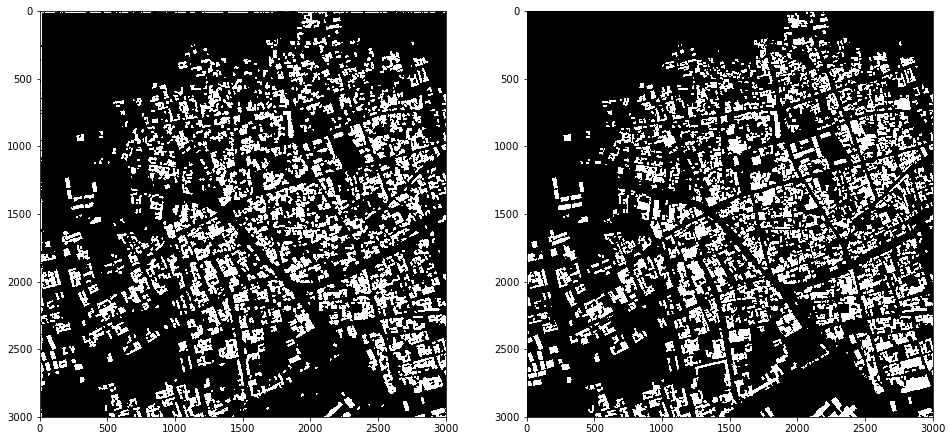

In [137]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.5).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [138]:
np.mean(predictions), np.std(predictions)

(0.22709602, 0.40978962)

beta1=0.8, beta2=0.99, lr = 0.001, loss = cross - log (jaccard), with lr decay. This is the best model up until now.

3: 0.46 big chunks
4: 0.11 a lot missing parts
5: 0.2 a lot of clusters
6: 0.44 big chunks
7: 0.19 nice one
8: 0.19 nice one
9: 0.23 nice one
10: 0.23 nice one
11: 0.23 nice one
12: 0.24 nice one
13: 0.23 nice one
14: 0.24 nice one
15: 0.22 nice one
16: 0.23 nice one
17: 0.23 nice one
18: 0.23 nice one
19: 0.23 nice one
20: 0.23 nice one

This loss function has never produced very nice result. I should probably abondon this loss function.
Another experiment was done with almost the same parameters but or of 0.01. The results oscillates. So This loss function also works, but lr of 0.001 is the best.

'log_dir/8-13_17-48_combo-jaccard/ckpt/ckpt-7001'


'log_dir/8-12_14-32_combo-jaccard/ckpt/ckpt-16001'
20: 0.072345264 very sparse
19: 0.072345264 very sparse
18: 0.02 super sparse
17: 0.48 a bit full
16: 0.1 too sparse
15: 0.14 too sparse
14: 0.36 OK kinda too full
13: 0.2 better than 12
12: 0.18 best, still some parts missing
11: 0.03 flat
10: 0.03 flat
9: 0.97 flat
8: 1.0 flat 
7: ~0.5 best
6: ~1.0 flat
5: ~0.98 flat
4: 0.23 best OK rough image with strips
3: 1.0 flat

model 14 misclassifies road as buildings, model 13 doesn't
model 13 can also make good predictions on images with no buildings (true labels). Model trained with images not including the no true label ones, would totally misclassfy these images

The result is oscillating!!

If the class is highly imblanced, you have to use really large batch size and large momentum, to make sure that the statistics of each effective (taking into account of the momentum) agrees with the statistics of whole training data set. Otherwise, the loss and accuracy will be oscillating.

In [ ]:
np.mean(log), np.std(log)

In [ ]:
fig, axs = plt.subplots(1,2, figsize = [16, 8])
axs[0].imshow((predictions > 0.8).astype(int)[0: 3000, 0: 3000], cmap = matplotlib.cm.gray)
axs[1].imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [ ]:
fig, axs = plt.subplots(figsize = [20, 20])
axs.imshow(img_data.label[0: 3000, 0: 3000, 0], cmap = matplotlib.cm.gray)

In [ ]:
np.mean(predictions), np.std(predictions)

In [ ]:
data_utils.image_IDs_dict

In [ ]:
predictions

In [ ]:
predictions[:20,:20]

In [ ]:
train_utils.test_ids

In [ ]:
reload(train_utils)

In [ ]:
for i in range(10): print sorted(train_utils.generate_train_ids(i))

In [ ]:
train_utils.test_ids

In [ ]:
train_utils.train_ids

In [ ]:
train_utils.generate_train_ids(0)

cross entropy loss with no learning rate decay

'log_dir/8-12_18-12_cross_entropy/ckpt/ckpt-11001'

11: 1. flat
10: 0.06 flat
9: 0.1 flat
8: 0.6, big chunk
7: 0.95 flat
6: 1.0 flat
5: 0.1 flat
4: ~1, flat
3: ~0.95, flat
2: 0.5 +- 0.5, pure strips!

For lr of 0.1 and cross entropy loss balanced by the class weight, the training was never able to produce a working model. And the prediction is oscillating between 0.1 and 1

I should try smaller lr of 0.001 and apply lr decay.

cross entropy loss with no learning rate decay

'log_dir/8-13_5-21_cross_entropy/ckpt/ckpt-2001'
start lr 0.001, this model again can never produce a stable working model. The mean prediction oscillates between 0.1 and 1. As the learning rate decays, the model converges to a model that tends to produce more true label prediction. ~50%. While the actual value is around 20%. This may be caused by the class balancing.

In conclusion, cross entropy loss doesn't work! I need much larger mini batch to prevent performance oscillation.

2: 0.97 flat
3: 0.83 kinda flat
4: 0.3 OK, a bit full
5: 0.43, very full
6: 0.14 very sparse
7: 0.9 flat
8: 0.8 kinda full
9: 0.6 kinda full
10: 0.5 kinda full
11: 0.5 kinda full
12: 0.5 kinda full
13: 0.57 too full
14: 0.55 too full